In [1]:
import numpy as np
import pandas as pd

import os
import random

import warnings

warnings.filterwarnings(action='ignore')

path = '/opt/ml/input/data/'
dat = pd.read_csv(path + 'FE_total2.csv')


In [2]:
dat.drop(['day','year','KnowledgeTag', 'last_answerCode7','last_answerCode8','last_answerCode9','last_answerCode10'], axis = 1, inplace = True)

In [3]:
_train = dat[dat['answerCode'] >= 0]
_test = dat[dat['answerCode'] < 0]

In [4]:
# valid 제작하는 함수 새로 개편.
# 예전 valid 제작 함수는 1분 걸렸는데 0.6초만에 끗~
_train['train_valid'] = 0
_train.loc[_train.drop_duplicates(subset='userID', keep = 'last').index, 'train_valid'] = -1
_valid = _train[_train['train_valid'] == -1]
_train = _train[_train['train_valid'] == 0]

In [5]:
# 모델에 적용하기 전 기본적인 데이터 전처리 부분
## 라벨링, 필요없는 칼럼 제거
_train_value = _train['answerCode']
_train.drop(['Timestamp', 'testId', 'train_valid', 'answerCode'], axis = 1, inplace = True) # ,'category_st_qcut_5'

_valid_value = _valid['answerCode']
_valid.drop(['Timestamp', 'testId', 'train_valid', 'answerCode'], axis = 1, inplace = True) # ,'category_st_qcut_5'

_test.drop(['Timestamp', 'testId', 'answerCode'], axis = 1, inplace = True) # ,'category_st_qcut_5'

In [6]:
# CatBoost에 적용하기 위해선 문자열 데이터로 변환 필요.
# 만약 범주형이 아니고 연속형(정수, 소수) 성질을 살리고 싶은 변수는 여기 drop에 적어두면 됨.(solve_time 같이.)
cat_columns = list(_train.drop(['solve_time','month'],axis=1).columns)

for col in cat_columns:
    _train[col] = _train[col].astype('str')
    _valid[col] = _valid[col].astype('str')
    _test[col] = _test[col].astype('str')

In [7]:
#!pip install optuna
#!pip install catboost
import gc
from sklearn.metrics import accuracy_score, roc_auc_score
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt


def objective(trial, FEATURE, train, valid, test, train_value, valid_value):
    
    param = {
    "task_type" : "GPU",
    "eval_metric" : 'AUC',
    "devices" : '0',
    'random_state' : trial.suggest_int("random_state", 1, 50000),
    'learning_rate': 0.08,#trial.suggest_loguniform('learning_rate', 0.01, 0.05),
    'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 0.1),
    'iterations': 500, #trial.suggest_int("iterations", 500, 2000),
    'max_depth': trial.suggest_int("max_depth", 8, 12),
    'random_strength': trial.suggest_int("random_strength", 1, 50),
    'l2_leaf_reg': trial.suggest_float("l2_leaf_reg",1e-5,9e-5),
    #"colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
    'min_child_samples': trial.suggest_int("min_child_samples", 5, 100), 
    'max_bin': trial.suggest_int("max_bin", 200, 500), 
    'od_type': 'Iter',
    "cat_features" : FEATURE,
    }
    
    # param = {
    # "task_type" : "GPU",
    # "eval_metric" : 'AUC',
    # "devices" : '0',
    # 'random_state' : 19991028,
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
    # 'iterations': 9000,
    # 'max_depth': 11,
    # 'od_type': 'Iter',
    # "cat_features" : cat_columns,
    # 'bagging_temperature': 0.36391590193742546, 
    # 'random_strength': 9, 
    # 'l2_leaf_reg': 6.803149112111853e-06, 
    # 'min_child_samples': 93, 
    # 'max_bin': 237
    # }
    
    model = CatBoostClassifier(**param)
    model.fit(train, train_value, early_stopping_rounds=100, verbose=10, eval_set=(_valid, _valid_value))
    
    # print('train score')
    # train_pred = model.predict_proba(train[FEATURE])[:,1]
    # print(roc_auc_score(train_value, train_pred)) # auc
    # print(accuracy_score(train_value, np.where(train_pred >= 0.5, 1, 0))) # acc, 정확도

    # print('valid score')
    valid_pred = model.predict_proba(valid)[:,1]
    # print(roc_auc_score(valid_value, valid_pred)) # auc
    # print(accuracy_score(valid_value, np.where(valid_pred >= 0.5, 1, 0))) # acc, 정확도

    # feature_importance = model.feature_importances_
    # sorted_idx = np.argsort(feature_importance)
    # fig = plt.figure(figsize=(12, 6))
    # plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
    # plt.yticks(range(len(sorted_idx)), np.array(_valid.columns)[sorted_idx])
    # plt.title("Feature Importance")


    return roc_auc_score(valid_value, valid_pred)

***optuna 적용***

In [8]:
import optuna
sampler = optuna.samplers.TPESampler(seed=2022128)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'maximize',
    sampler = sampler,
)
study.optimize(lambda trial : objective(trial, cat_columns, _train, _valid, _test, _train_value, _valid_value), n_trials=30)

[I 2022-12-09 01:24:56,325] A new study created in memory with name: cat_parameter_opt
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7795275	best: 0.7795275 (0)	total: 299ms	remaining: 2m 28s
10:	test: 0.8130192	best: 0.8130192 (10)	total: 3.21s	remaining: 2m 22s
20:	test: 0.8204705	best: 0.8204705 (20)	total: 6.06s	remaining: 2m 18s
30:	test: 0.8251718	best: 0.8251718 (30)	total: 9.24s	remaining: 2m 19s
40:	test: 0.8275367	best: 0.8275367 (40)	total: 12s	remaining: 2m 14s
50:	test: 0.8298092	best: 0.8298250 (49)	total: 14.6s	remaining: 2m 8s
60:	test: 0.8311184	best: 0.8311184 (60)	total: 17.4s	remaining: 2m 5s
70:	test: 0.8322675	best: 0.8322675 (70)	total: 20s	remaining: 2m
80:	test: 0.8330896	best: 0.8330896 (80)	total: 23.3s	remaining: 2m
90:	test: 0.8340165	best: 0.8340165 (90)	total: 26.5s	remaining: 1m 59s
100:	test: 0.8346128	best: 0.8346128 (100)	total: 29.5s	remaining: 1m 56s
110:	test: 0.8350601	best: 0.8350601 (110)	total: 32.5s	remaining: 1m 53s


[W 2022-12-09 01:25:41,735] Trial 0 failed because of the following error: KeyboardInterrupt('')
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122456/745123171.py", line 8, in <lambda>
    study.optimize(lambda trial : objective(trial, cat_columns, _train, _valid, _test, _train_value, _valid_value), n_trials=30)
  File "/tmp/ipykernel_122456/2267074974.py", line 49, in objective
    model.fit(train, train_value, early_stopping_rounds=100, verbose=10, eval_set=(_valid, _valid_value))
  File "/opt/conda/lib/python3.8/site-packages/catboost/core.py", line 5128, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.8/site-packages/catboost/core.py", line 2355, in _fit
    self._train(
  File "/opt/conda/lib/python3.8/site-pac

KeyboardInterrupt: 

***feature 중요도***

Text(0.5, 1.0, 'Feature Importance')

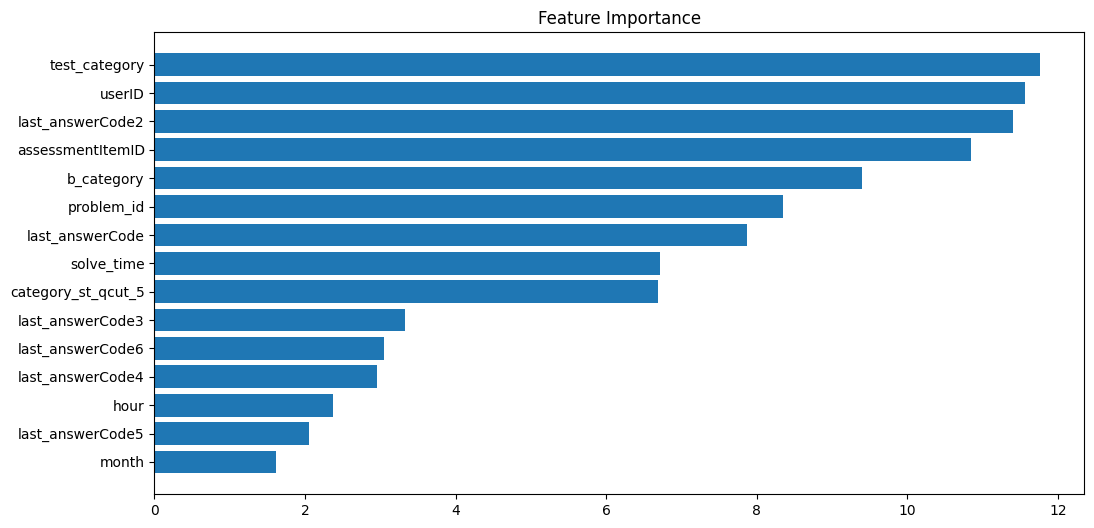

In [11]:
import matplotlib.pyplot as plt

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(_valid.columns)[sorted_idx])
plt.title("Feature Importance")

***optuna에서 나왔던 값들로 param 돌려보기***

In [ ]:

#best param
param = {
    "task_type" : "GPU",
    "eval_metric" : 'AUC',
    "devices" : '0',
    'learning_rate': 0.01,#trial.suggest_loguniform('learning_rate', 0.01, 0.05),
    'iterations': 4000, #trial.suggest_int("iterations", 500, 2000),
    'od_type': 'Iter',
    "cat_features" : cat_columns,
    'random_state': 5753, 
    'bagging_temperature': 0.013328266865025943, 
    'max_depth': 11, 
    'random_strength': 16, 
    'l2_leaf_reg': 6.530922242678823e-05, 
    'min_child_samples': 72, 
    'max_bin': 229
    }


model = CatBoostClassifier(**param)
model.fit(_train, _train_value, early_stopping_rounds=1000, verbose=10, eval_set=(_valid, _valid_value))


In [ ]:
print('train score')
test_pred = model.predict_proba(_train)[:,1]
print(roc_auc_score(_train_value, test_pred)) # auc
print(accuracy_score(_train_value, np.where(test_pred >= 0.5, 1, 0))) # acc, 정확도

print('valid score')
test_pred = model.predict_proba(_valid)[:,1]
print(roc_auc_score(_valid_value, test_pred)) # auc
print(accuracy_score(_valid_value, np.where(test_pred >= 0.5, 1, 0))) # acc, 정확도

In [ ]:
# submission 제출하기 위한 코드
test_pred = model.predict_proba(_test)[:,1]
_test['prediction'] = test_pred
submission = _test['prediction'].reset_index(drop = True).reset_index()
submission.rename(columns = {'index':'id'}, inplace = True)
submission.to_csv('../output/cat_v1.csv', index = False)